# Will the Ad be clicked?

## Installing libraries, dependencies, and data

In [1]:
# Import the required libraries and dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Read csv file as DataFrame, with the first column as row index
df = pd.read_csv("Dataset_Ads.csv")

# Preview the dataset
df.tail()

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
9995,7,Male,69925.29,Rural,Text,Fashion,Social Media,5,2023-05-31 20:45:56.927349,0.2460,0.1045
9996,35,Male,42182.75,Urban,Native,Technology,Website,9,2023-09-01 20:45:56.927349,0.2664,0.0407
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine,3,2023-11-15 20:45:56.927349,0.2354,0.0390
9998,34,Male,39382.80,Rural,Native,Technology,Social Media,4,2023-05-23 20:45:56.927349,0.1725,0.0455
9999,54,Female,66441.59,Suburban,Banner,Technology,Search Engine,2,2023-11-21 20:45:56.927349,0.0307,0.0323


## Data Cleanup and Preparation

In [3]:
# Checking the data types
df.dtypes

Age                  int64
Gender              object
Income             float64
Location            object
Ad Type             object
Ad Topic            object
Ad Placement        object
Clicks               int64
Click Time          object
Conversion Rate    float64
CTR                float64
dtype: object

In [4]:
# Checking for null values
df.isna().sum() / len(df)

Age                0.0
Gender             0.0
Income             0.0
Location           0.0
Ad Type            0.0
Ad Topic           0.0
Ad Placement       0.0
Clicks             0.0
Click Time         0.0
Conversion Rate    0.0
CTR                0.0
dtype: float64

In [5]:
# Remove ages that are below 18; This is under the assumption that users below 18 are not going to be converted into sales.
# Asked XPert Learning Assistant for code
df = df[df["Age"] >= 18]
df.tail()

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
9994,49,Female,72810.17,Rural,Banner,Technology,Website,9,2023-07-24 20:45:56.927349,0.0679,0.0443
9996,35,Male,42182.75,Urban,Native,Technology,Website,9,2023-09-01 20:45:56.927349,0.2664,0.0407
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine,3,2023-11-15 20:45:56.927349,0.2354,0.0390
9998,34,Male,39382.80,Rural,Native,Technology,Social Media,4,2023-05-23 20:45:56.927349,0.1725,0.0455
9999,54,Female,66441.59,Suburban,Banner,Technology,Search Engine,2,2023-11-21 20:45:56.927349,0.0307,0.0323


In [6]:
# Creating a DataFrame for the X (features) value
X = df.drop(columns=["Clicks", "Click Time", "Conversion Rate","CTR"])
X

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement
0,61,Male,35717.43,Urban,Banner,Travel,Social Media
1,41,Male,47453.25,Rural,Video,Travel,Search Engine
2,49,Female,68126.35,Rural,Text,Food,Social Media
3,68,Female,64585.73,Suburban,Text,Health,Website
4,63,Male,21109.40,Urban,Native,Fashion,Search Engine
...,...,...,...,...,...,...,...
9994,49,Female,72810.17,Rural,Banner,Technology,Website
9996,35,Male,42182.75,Urban,Native,Technology,Website
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine
9998,34,Male,39382.80,Rural,Native,Technology,Social Media


In [7]:
# Creating DataFrames for the y (target) values
y_clicks = df["Clicks"]
y_conversion = df["Conversion Rate"]
y_ctr = df["CTR"]
y_clicks



0       3
1       5
2       4
3       6
4       5
       ..
9994    9
9996    9
9997    3
9998    4
9999    2
Name: Clicks, Length: 8694, dtype: int64

In [8]:
y_conversion

0       0.0981
1       0.0937
2       0.1912
3       0.1122
4       0.1426
         ...  
9994    0.0679
9996    0.2664
9997    0.2354
9998    0.1725
9999    0.0307
Name: Conversion Rate, Length: 8694, dtype: float64

In [9]:
y_ctr

0       0.0737
1       0.0592
2       0.0563
3       0.0232
4       0.0539
         ...  
9994    0.0443
9996    0.0407
9997    0.0390
9998    0.0455
9999    0.0323
Name: CTR, Length: 8694, dtype: float64

In [10]:
# Creating a OneHotEncoder column function
def oheEncodeColumn(X_df, X_column):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_column = ohe.fit(X_df[X_column].values.reshape(-1, 1))
    return encoded_column

In [11]:
# This is a column that might contain variables with a specific order
X["Location"].value_counts()

Location
Rural       2960
Suburban    2877
Urban       2857
Name: count, dtype: int64

In [12]:
# Creating an OrdinalEncoder column function
def ordEncodeColumn(X_df, X_column):
    ord = OrdinalEncoder(categories=[["Rural", "Suburban", "Urban"]], encoded_missing_value=-1, handle_unknown="use_encoded_value", unknown_value=-1)
    encoded_column = ord.fit(X_df[X_column].values.reshape(-1, 1))
    return encoded_column

In [13]:
# Creating an encode function
def X_preprocess(X_data):
    # Creating an encoder for each X column
    # and Transforming them into numpy arrays

    # Gender column
    gender_ohe = oheEncodeColumn(X_data, "Gender")
    gender_encoded = gender_ohe.transform(X_data["Gender"].values.reshape(-1,1))
    # Location column
    location_ord = ordEncodeColumn(X_data, "Location")
    location_encoded = location_ord.transform(X_data["Location"].values.reshape(-1,1))
    # Ad Type column
    type_ohe = oheEncodeColumn(X_data, "Ad Type")
    type_encoded = type_ohe.transform(X_data["Ad Type"].values.reshape(-1,1))
    # Ad Topic column
    topic_ohe = oheEncodeColumn(X_data, "Ad Topic")
    topic_encoded = topic_ohe.transform(X_data["Ad Topic"].values.reshape(-1,1))
    # Ad Placement column
    placement_ohe = oheEncodeColumn(X_data, "Ad Placement")
    placement_encoded = placement_ohe.transform(X_data["Ad Placement"].values.reshape(-1,1))

    # Turning each numpy array into a DataFrame
    gender_df = pd.DataFrame(gender_encoded, columns=gender_ohe.get_feature_names_out())
    type_df = pd.DataFrame(type_encoded, columns=type_ohe.get_feature_names_out())
    topic_df = pd.DataFrame(topic_encoded, columns=topic_ohe.get_feature_names_out())
    placement_df = pd.DataFrame(placement_encoded, columns=placement_ohe.get_feature_names_out())

    # Creating an encoded DataFrame
    out_df = pd.concat([gender_df, type_df, topic_df, placement_df], axis=1)
    out_df["Location"] = location_encoded
    out_df["Age"] = df["Age"]
    out_df["Income"] = df["Income"]
    # Return the DataFrame
    return out_df



## Question 1: Which features have the strongest influence on clicking of an Ad?
Which features have the strongest influence on clicking of an Ad?
"Age" and "Income" has the strongest influence on PCA1 and PCA2.

In [14]:
# Scale the X data by using StandardScaler()
X_scaled = StandardScaler().fit_transform(X [["Age", "Income"]])
X_scaled


array([[ 1.90930384, -0.71067545],
       [ 0.26112309, -0.12495413],
       [ 0.92039539,  0.90681658],
       ...,
       [ 0.34353213,  0.25589384],
       [-0.31574017, -0.52774104],
       [ 1.33244058,  0.82273214]])

In [15]:
X_scaled = pd.DataFrame(X_scaled, columns=["Age", "Income"])
X_scaled

,Age,Income
0,1.909304,-0.710675
1,0.261123,-0.124954
2,0.920395,0.906817
3,2.486167,0.730108
4,2.074122,-1.439745
...,...,...
8689,0.920395,1.140581
8690,-0.233331,-0.387999
8691,0.343532,0.255894
8692,-0.315740,-0.527741


In [16]:
preprocess_X = X_preprocess(X)
preprocess_X = preprocess_X.drop(columns="x0_Female")
preprocess_X

,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,61.0,35717.43
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,41.0,47453.25
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49.0,68126.35
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,68.0,64585.73
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,63.0,21109.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8689,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,51.0,48175.94
8690,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,40.0,39445.38
8691,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,24.0,56537.25
8692,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,33.0,50267.70


In [17]:
preprocess_X["Age"] = X_scaled["Age"]
preprocess_X["Income"] = X_scaled["Income"]
preprocess_X

,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.909304,-0.710675
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.261123,-0.124954
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.920395,0.906817
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.486167,0.730108
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.074122,-1.439745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8689,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.920395,1.140581
8690,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.233331,-0.387999
8691,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.343532,0.255894
8692,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.315740,-0.527741


In [18]:
# #Using PCA for feature analysis
# PCA weight for the desired number of components (e.g., 2)
pca = PCA(n_components=2)
pca_info = pca.fit_transform(preprocess_X)
pca_info

array([[ 1.86177399,  0.9072693 ],
       [ 0.18190138,  0.18044123],
       [ 0.95844367, -0.78382252],
       ...,
       [ 0.38196305, -0.20603586],
       [-0.44966716,  0.48297395],
       [ 1.43407004, -0.65035443]])

In [19]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.190281  , 0.19010573])

In [20]:
# Create the PCA DataFrame
pca_df = pd.DataFrame(
    pca_info, 
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
pca_df.head()

,PCA1,PCA2
0,1.861774,0.907269
1,0.181901,0.180441
2,0.958444,-0.783823
3,2.548659,-0.399946
4,1.954916,1.668575


In [21]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model 
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=0)
    k_model.fit(pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}

# Create the DataFrame from the elbow data
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow


,k,inertia
0,1,17405.319302
1,2,11568.781805
2,3,7534.332345
3,4,6094.649462
4,5,5071.539950
5,6,4237.574742
6,7,3684.633835
7,8,3361.027882
8,9,3015.905748
9,10,2641.984979


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

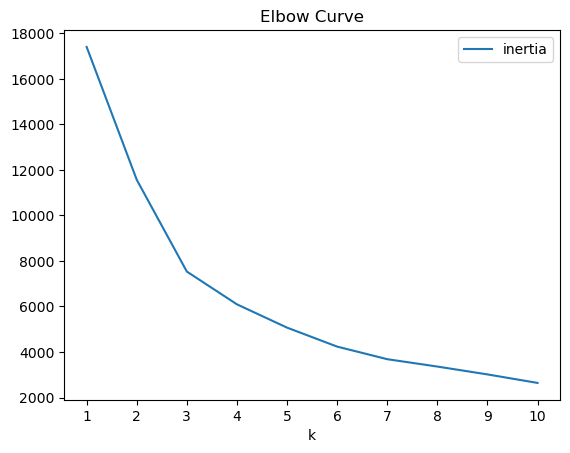

In [22]:
# Plot the DataFrame
df_elbow.plot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

In [23]:
# Define the model Kmeans model using the optimal value of k for the number of clusters.
model = KMeans(n_clusters=3, n_init='auto', random_state=0)

# Fit the model
model.fit(pca_df)

# Make predictions
k_3 = model.predict(pca_df)

# Create a copy of the customers_pca_df DataFrame
pca_predictions_df =pca_df.copy()

# Add a class column with the labels
pca_predictions_df["Ad Encounter"] = k_3
pca_predictions_df

,PCA1,PCA2,Ad Encounter
0,1.861774,0.907269,0
1,0.181901,0.180441,1
2,0.958444,-0.783823,0
3,2.548659,-0.399946,0
4,1.954916,1.668575,0
...,...,...,...
8689,0.986720,-0.991920,0
8690,-0.220544,0.349798,1
8691,0.381963,-0.206036,0
8692,-0.449667,0.482974,1


<Axes: xlabel='PCA1', ylabel='PCA2'>

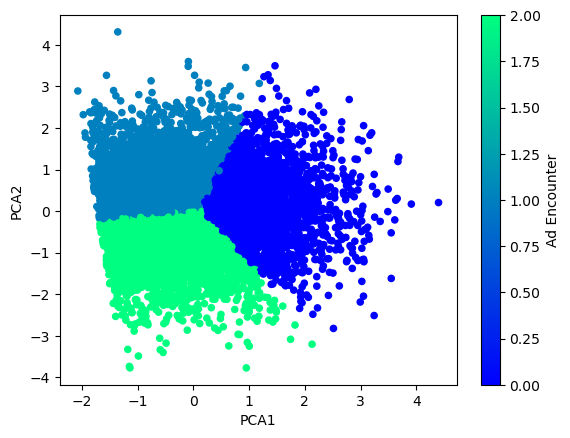

In [24]:
# Plot the data points based on the Clicks
pca_predictions_df.plot.scatter(
    x="PCA1", 
    y="PCA2",
    c="Ad Encounter", 
    colormap='winter')


In [25]:
# Define the model Kmeans model using the optimal value of k for the number of clusters.
model = KMeans(n_clusters=3, n_init='auto', random_state=0)

# Fit the model
model.fit(preprocess_X)

# Make predictions
k_3 = model.predict(preprocess_X)

# Create a copy of the customers_pca_df DataFrame
X_predictions_df =preprocess_X.copy()

# Add a class column with the labels
X_predictions_df["Ad Encounter"] = k_3
X_predictions_df

,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income,Ad Encounter
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.909304,-0.710675,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.261123,-0.124954,1
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.920395,0.906817,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.486167,0.730108,0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.074122,-1.439745,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8689,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.920395,1.140581,0
8690,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.233331,-0.387999,1
8691,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.343532,0.255894,0
8692,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.315740,-0.527741,1


In [26]:
# Determine which feature has the stronger influence on each principal component. 
# Use the columns from the original DataFrame. FYI: The data has already been scaled and fitted.
pca_component_weights = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=preprocess_X.columns)
pca_component_weights

,PCA1,PCA2
x0_Male,-0.001891,0.003800
x0_Other,0.000067,0.002085
x0_Banner,0.003312,-0.001139
x0_Native,-0.000203,-0.002428
x0_Text,0.001308,0.001052
x0_Video,-0.004416,0.002515
x0_Fashion,0.003950,-0.003337
x0_Finance,-0.000695,-0.001854
x0_Food,0.002886,0.002427
x0_Health,-0.002211,0.004675


<Axes: xlabel='Income', ylabel='Age'>

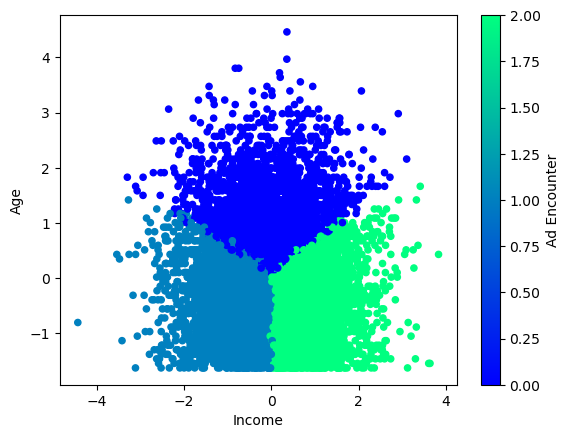

In [27]:
# Plot the data points based on Ad Encounter (who clicked the Ad and what the Ad was for - this section is to verify that our predictions match the PCA)
X_predictions_df.plot.scatter(
    x="Income", 
    y="Age",
    c="Ad Encounter", 
    colormap='winter')

## Question 2: Can a Regression Model predict the Click Through Rate of an Ad?
Based on the results of the principal component analysis Age, and Income have a high loading, possibly implicating that they are significant variables in the dataset. Next, train test split was run on the data solely analyzing click through rate (CTR) on the full and select variables and then scaled the select data in order to perform linear regression on both sets of data.
R2 values range from 0 to1 with a 1 indicating that the regression model predictions fit the data perfectly. The r2 values of -0.005 and -0.002. This indicates that the linear regression model does not explain the variability of the data. Overall, the changes in the dependent variable CTR are not completely explained by the changes in the independent variables, demonstrating that a Regression Model cannot predict the click through rate of an ad.

In [28]:
X_full = X
X_sel = X[["Age", "Income"]]
X_sel

,Age,Income
0,61,35717.43
1,41,47453.25
2,49,68126.35
3,68,64585.73
4,63,21109.40
...,...,...
9994,49,72810.17
9996,35,42182.75
9997,42,55084.12
9998,34,39382.80


In [29]:
X_full_train, X_full_test, X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_full, X_sel,  y_ctr, random_state=42)

In [30]:
X_full_train_scaled = StandardScaler().fit_transform(X_full_train[["Age", "Income"]])
X_full_test_scaled = StandardScaler().fit_transform(X_full_test[["Age", "Income"]])
X_full_train_scaled

array([[ 1.50185341, -1.53278454],
       [ 0.67750675, -0.00926443],
       [ 0.84237608,  1.21667452],
       ...,
       [-0.31170924, -0.18338886],
       [ 0.01802942,  1.5780552 ],
       [ 1.08968008, -1.50220395]])

In [31]:
X_full_train_scaled = pd.DataFrame(X_full_train_scaled, columns=["Age", "Income"])
X_full_test_scaled = pd.DataFrame(X_full_test_scaled, columns=["Age", "Income"])
X_full_train_scaled

,Age,Income
0,1.501853,-1.532785
1,0.677507,-0.009264
2,0.842376,1.216675
3,1.336984,-0.644622
4,0.512637,-0.175914
...,...,...
6515,3.068112,0.825413
6516,3.232981,-1.675801
6517,-0.311709,-0.183389
6518,0.018029,1.578055


In [32]:
X_full_train_preprocess = X_preprocess(X_full_train)
X_full_test_preprocess = X_preprocess(X_full_test)
X_full_train_preprocess

,x0_Female,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,61.0,35717.43
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,41.0,47453.25
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,49.0,68126.35
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,68.0,64585.73
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,63.0,21109.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
6516,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN
6517,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,-5928.87
6518,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,75045.86


In [33]:
X_full_train_preprocess["Age"] = X_full_train_scaled["Age"]
X_full_train_preprocess["Income"] = X_full_train_scaled["Income"]
X_full_test_preprocess["Age"] = X_full_test_scaled["Age"]
X_full_test_preprocess["Income"] = X_full_test_scaled["Income"]
X_full_train_preprocess

,x0_Female,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.501853,-1.532785
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.677507,-0.009264
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.842376,1.216675
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.336984,-0.644622
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.512637,-0.175914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.068112,0.825413
6516,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.232981,-1.675801
6517,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.311709,-0.183389
6518,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.018029,1.578055


In [34]:
X_sel_train_preprocess = StandardScaler().fit_transform(X_sel_train)
X_sel_test_preprocess = StandardScaler().fit_transform(X_sel_test)
X_sel_train_preprocess

array([[ 1.50185341, -1.53278454],
       [ 0.67750675, -0.00926443],
       [ 0.84237608,  1.21667452],
       ...,
       [-0.31170924, -0.18338886],
       [ 0.01802942,  1.5780552 ],
       [ 1.08968008, -1.50220395]])

In [35]:
lr1 = LinearRegression()
lr2 = LinearRegression()

In [36]:
lr1.fit(X_full_train_preprocess, y_train)
lr2.fit(X_sel_train_preprocess, y_train)

LinearRegression()

In [37]:
predicted1 =lr1.predict(X_full_test_preprocess)
predicted2 = lr2.predict(X_sel_test_preprocess)

In [38]:
r21 = round(r2_score(y_test, predicted1),3)
r22 = round(r2_score(y_test, predicted2),3)

print(f"The r2 is {r21}.")
print(f"The r2 is {r22}.")

The r2 is -0.007.
The r2 is -0.001.


## Question 3: Can a Classification model predict if someone clicks on an ad?
[According to a blog post from Neil Patel (n.d.)](https://neilpatel.com/blog/what-is-the-optimum-number-of-clicks-before-conversions-start-happening/#:~:text=It%E2%80%99s%20a%20good%20strategy%20to%20directly%20pitch%20your,product%20page%2C%20will%20lead%20to%20a%20website%20conversion.), it takes at least 2 clicks to convert a user into a customer. The code uses a slice of the DataFrame that only contains rows with the amount of clicks being from 0-3. After doing a train-test-split, the X data is scaled and encoded and the y data is the clicks column encoded as "Yes" for rows with 2-3 clicks and "No" for rows with 0-1 clicks. I used the Random Forest Classifier as my model, and I calculated the maximum depth that produces the most accurate results looping through max depths 1-15. The model trained with a max depth of 8 had an accuracy score of 85%. I made several attemps to resample the data, and I when I did it with the SMOTE sampler it produced an accuracy of 81%, but with a higher accuracy for "No" results.

In [39]:
df["Clicks"].value_counts()

Clicks
4     1528
5     1512
6     1266
3     1202
7      884
2      721
8      597
9      344
1      278
10     167
0       72
11      72
12      34
13       8
14       6
15       2
17       1
Name: count, dtype: int64

In [40]:
# Creating a new DataFrame that only has instances of users interacting with an ad with 0-2 clicks
clicks_df = df[df["Clicks"] <= 3]
clicks_df

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
0,61,Male,35717.43,Urban,Banner,Travel,Social Media,3,2024-01-18 20:45:56.898459,0.0981,0.0737
8,33,Male,25917.02,Rural,Video,Food,Search Engine,3,2023-10-05 20:45:56.898459,0.0347,0.0488
10,37,Male,23818.88,Rural,Banner,Food,Search Engine,2,2023-11-24 20:45:56.898459,0.2038,0.0530
13,36,Male,56217.30,Rural,Native,Fashion,Search Engine,3,2023-09-07 20:45:56.898459,0.1816,0.0588
18,39,Male,83984.08,Suburban,Native,Food,Search Engine,2,2024-03-13 20:45:56.898459,0.2154,0.0710
...,...,...,...,...,...,...,...,...,...,...,...
9982,36,Male,73173.74,Rural,Banner,Food,Social Media,1,2024-01-09 20:45:56.927349,0.2495,0.0657
9984,22,Female,43235.45,Rural,Banner,Travel,Search Engine,3,2024-02-19 20:45:56.927349,0.1734,0.0750
9987,35,Male,37732.04,Suburban,Banner,Fashion,Search Engine,3,2023-10-13 20:45:56.927349,0.0417,0.0216
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine,3,2023-11-15 20:45:56.927349,0.2354,0.0390


In [41]:
# Creating a DataFrame for the X (features) value
clicks_X = clicks_df.drop(columns=["Clicks", "Click Time", "Conversion Rate","CTR"])
clicks_X

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement
0,61,Male,35717.43,Urban,Banner,Travel,Social Media
8,33,Male,25917.02,Rural,Video,Food,Search Engine
10,37,Male,23818.88,Rural,Banner,Food,Search Engine
13,36,Male,56217.30,Rural,Native,Fashion,Search Engine
18,39,Male,83984.08,Suburban,Native,Food,Search Engine
...,...,...,...,...,...,...,...
9982,36,Male,73173.74,Rural,Banner,Food,Social Media
9984,22,Female,43235.45,Rural,Banner,Travel,Search Engine
9987,35,Male,37732.04,Suburban,Banner,Fashion,Search Engine
9997,42,Male,55084.12,Suburban,Text,Finance,Search Engine


In [42]:
# Creating DataFrames for the y (target) values
clicks_y = clicks_df["Clicks"]
clicks_y

0       3
8       3
10      2
13      3
18      2
       ..
9982    1
9984    3
9987    3
9997    3
9999    2
Name: Clicks, Length: 2273, dtype: int64

In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clicks_X, clicks_y, random_state=42)
X_train.describe()

,Age,Income
count,1704.000000,1704.000000
mean,37.481808,49902.143644
std,11.800690,19680.688781
min,18.000000,-18644.310000
25%,29.000000,36549.147500
50%,36.000000,50049.285000
75%,45.000000,62443.987500
max,86.000000,126635.800000


In [44]:
X_train_scaled = StandardScaler().fit_transform(X_train[["Age", "Income"]])
X_test_scaled = StandardScaler().fit_transform(X_test[["Age", "Income"]])
X_train_scaled

array([[-0.54943486, -0.5134637 ],
       [-0.54943486,  0.60082737],
       [ 2.2478328 , -0.47606785],
       ...,
       [-0.80373192,  2.07492741],
       [-0.2951378 ,  1.19398222],
       [ 0.63728475,  1.4619585 ]])

In [45]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=["Age", "Income"])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=["Age", "Income"])
X_train_scaled

,Age,Income
0,-0.549435,-0.513464
1,-0.549435,0.600827
2,2.247833,-0.476068
3,-1.481857,0.612500
4,0.382988,-0.778784
...,...,...
1699,2.078301,-0.447035
1700,1.230645,0.701104
1701,-0.803732,2.074927
1702,-0.295138,1.193982


In [46]:
# Encode the X data with the X_preprocess function
X_train_encoded = X_preprocess(X_train)
X_test_encoded = X_preprocess(X_test)
X_train_encoded

,x0_Female,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,61.0,35717.43
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,41.0,47453.25
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,49.0,68126.35
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,68.0,64585.73
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,63.0,21109.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,44.0,111757.88
1700,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1701,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,27.0,86915.35
1702,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,47.0,48621.82


In [47]:
X_train_encoded["Age"] = X_train_scaled["Age"]
X_train_encoded["Income"] = X_train_scaled["Income"]
X_test_encoded["Age"] = X_test_scaled["Age"]
X_test_encoded["Income"] = X_test_scaled["Income"]
X_train_encoded

,x0_Female,x0_Male,x0_Other,x0_Banner,x0_Native,x0_Text,x0_Video,x0_Fashion,x0_Finance,x0_Food,x0_Health,x0_Technology,x0_Travel,x0_Search Engine,x0_Social Media,x0_Website,Location,Age,Income
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.549435,-0.513464
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.549435,0.600827
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.247833,-0.476068
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-1.481857,0.612500
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.382988,-0.778784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.078301,-0.447035
1700,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.230645,0.701104
1701,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.803732,2.074927
1702,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.295138,1.193982


In [48]:
# Encoding the clicks column using a custom function
def encode_clicks(clicks):
    if clicks >= 2:
        return "Yes"
    else:
        return "No"
# Applying the function to y_train and y_test
y_train_encoded = y_train.apply(encode_clicks)
y_test_encoded = y_test.apply(encode_clicks)
y_train_encoded.value_counts()

Clicks
Yes    1439
No      265
Name: count, dtype: int64

In [49]:
# Create a loop to vary the max_depth parameter
# Make sure to record the train and test scores 
# for each pass.

# Depths should span from 1 up to 15 in steps of 1
depths = range(1, 15)

# The scores dataframe will hold depths and scores
# to make plotting easy
scores = {"train":[], "test":[], "depth":[]}

# Loop through each depth
for depth in depths:
    clf = RandomForestClassifier(max_depth=depth)
    clf.fit(X_train_encoded, y_train_encoded)

    train_score = clf.score(X_train_encoded, y_train_encoded)
    test_score = clf.score(X_test_encoded, y_test_encoded)

    scores["depth"].append(depth)
    scores["train"].append(train_score)
    scores["test"].append(test_score)

# Create a dataframe from the scores dictionary and
# set the index to depth
scores_df = pd.DataFrame(scores).set_index("depth")
scores_df.head()

,train,test
depth,,
1,0.844484,0.850615
2,0.844484,0.850615
3,0.844484,0.850615
4,0.844484,0.850615
5,0.844484,0.850615


<Axes: xlabel='depth'>

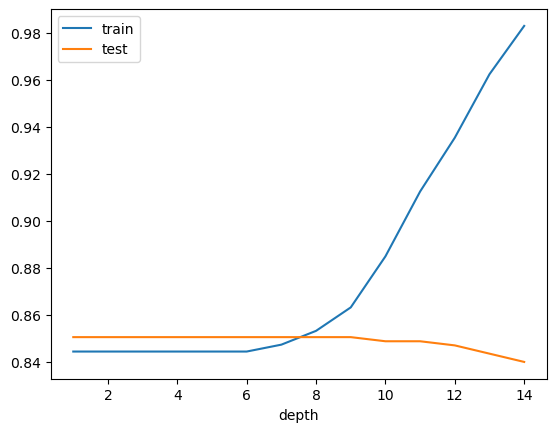

In [50]:
# Plot the scores dataframe with the plot method
scores_df.plot()

In [51]:
# Instantiate a RandomForestClassifier instance
model = RandomForestClassifier(max_depth=8, random_state=42)

# Fit the traning data to the model
model.fit(X_train_encoded, y_train_encoded)

RandomForestClassifier(max_depth=8, random_state=42)

In [52]:
y_pred = model.predict(X_test_encoded)

In [53]:
# Print classification reports
print(f"Classification Report - Original Data")
print(classification_report(y_test_encoded, y_pred))

Classification Report - Original Data
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        85
         Yes       0.85      1.00      0.92       484

    accuracy                           0.85       569
   macro avg       0.43      0.50      0.46       569
weighted avg       0.72      0.85      0.78       569



c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
# Instantiate the SMOTE instance 
# Set the sampling_strategy parameter equal to auto
smote_sampler = SMOTE(random_state=42, sampling_strategy='auto')

In [55]:
# Fit the training data to the smote_sampler model
X_resampled, y_resampled = smote_sampler.fit_resample(X_train_encoded, y_train_encoded)

In [56]:
# Count distinct values for the resampled target data
y_resampled.value_counts()

Clicks
Yes    1439
No     1439
Name: count, dtype: int64

In [57]:
# Instantiate a new RandomForestClassier model 
smote_model = RandomForestClassifier(max_depth=8, random_state=42)

# Fit the resampled data to the new model
smote_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=8, random_state=42)

In [58]:
# Predict labels for resampled testing features
smote_y_pred = smote_model.predict(X_test_encoded)

In [59]:
# Print classification reports
print(f"Classification Report - Original Data")
print(classification_report(y_test_encoded, y_pred))
print("---------")
print(f"Classification Report - Resampled Data - SMOTE")
print(classification_report(y_test_encoded, smote_y_pred))

Classification Report - Original Data
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        85
         Yes       0.85      1.00      0.92       484

    accuracy                           0.85       569
   macro avg       0.43      0.50      0.46       569
weighted avg       0.72      0.85      0.78       569

---------
Classification Report - Resampled Data - SMOTE
              precision    recall  f1-score   support

          No       0.13      0.05      0.07        85
         Yes       0.85      0.94      0.89       484

    accuracy                           0.81       569
   macro avg       0.49      0.50      0.48       569
weighted avg       0.74      0.81      0.77       569



c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Question 4: What is the most desirable ad?
We found that more men over the age of 30 years old who live in Rural , Suburban and Urban under both test data and train data found they are more intersted into the topics of Finance, Travel, and Fashion vs females. 

In [60]:
print(df.columns)
print(df)

Index(['Age', 'Gender', 'Income', 'Location', 'Ad Type', 'Ad Topic',
       'Ad Placement', 'Clicks', 'Click Time', 'Conversion Rate', 'CTR'],
      dtype='object')
      Age  Gender    Income  Location Ad Type    Ad Topic   Ad Placement  \
0      61    Male  35717.43     Urban  Banner      Travel   Social Media   
1      41    Male  47453.25     Rural   Video      Travel  Search Engine   
2      49  Female  68126.35     Rural    Text        Food   Social Media   
3      68  Female  64585.73  Suburban    Text      Health        Website   
4      63    Male  21109.40     Urban  Native     Fashion  Search Engine   
...   ...     ...       ...       ...     ...         ...            ...   
9994   49  Female  72810.17     Rural  Banner  Technology        Website   
9996   35    Male  42182.75     Urban  Native  Technology        Website   
9997   42    Male  55084.12  Suburban    Text     Finance  Search Engine   
9998   34    Male  39382.80     Rural  Native  Technology   Social Media   

In [61]:
# Count the total number of males
total_males = df[df['Gender'] == 'Male'].shape[0]

# Count the total number of females
total_females = df[df['Gender'] == 'Female'].shape[0]

# Create X and y variables
X = total_males
y = total_females

print("Total Males:", X)
print("Total Females:", y)

Total Males: 4316
Total Females: 3462


In [62]:
df_male = df[df['Gender'] == 'Male']
df_female = df[df['Gender'] == 'Female']

df_male.head()

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
0,61,Male,35717.43,Urban,Banner,Travel,Social Media,3,2024-01-18 20:45:56.898459,0.0981,0.0737
1,41,Male,47453.25,Rural,Video,Travel,Search Engine,5,2023-04-24 20:45:56.898459,0.0937,0.0592
4,63,Male,21109.40,Urban,Native,Fashion,Search Engine,5,2023-07-02 20:45:56.898459,0.1426,0.0539
5,20,Male,39576.44,Suburban,Video,Health,Social Media,5,2024-02-19 20:45:56.898459,0.1824,0.0424
8,33,Male,25917.02,Rural,Video,Food,Search Engine,3,2023-10-05 20:45:56.898459,0.0347,0.0488


In [63]:
# Assign the counts to X and y
# To get the records that are only males say somthing like



# Assigning counts to X and y 
X_df_male = df_male.drop("Clicks",axis=1)  # Total Males
X_df_female = df_female.drop("Clicks",axis=1)  # Total Females

y_df_male = df_male["Clicks"]
y_df_female = df_female["Clicks"]


In [64]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df_male, y_df_male, random_state=42)


# Displaying the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3237, 10)
X_test shape: (1079, 10)
y_train shape: (3237,)
y_test shape: (1079,)


In [65]:
# Splitting the data into training and testing sets (Female)
X_train_f,X_test_f, y_train_f, y_test_f = train_test_split(X_df_female, y_df_female, random_state=42)


# Displaying the shapes of the resulting arrays
print("X_train shape:", X_train_f.shape)
print("X_test shape:", X_test_f.shape)
print("y_train shape:", y_train_f.shape)
print("y_test shape:", y_test_f.shape)


X_train shape: (2596, 10)
X_test shape: (866, 10)
y_train shape: (2596,)
y_test shape: (866,)


In [66]:
# Display total counts for each unique value in 'Ad_types' column
ad_types_total = df['Ad Topic'].value_counts()
print(ad_types_total)

# Display total counts for each unique value in 'clicks' column
clicks_total = df['Clicks'].value_counts()
print("\nTotal counts for each click type:")
print(clicks_total)

Ad Topic
Finance       1492
Technology    1453
Food          1450
Fashion       1450
Travel        1448
Health        1401
Name: count, dtype: int64

Total counts for each click type:
Clicks
4     1528
5     1512
6     1266
3     1202
7      884
2      721
8      597
9      344
1      278
10     167
0       72
11      72
12      34
13       8
14       6
15       2
17       1
Name: count, dtype: int64


In [67]:
# Display what is the most Desiable or hihg Ad? using the Test data ( useing the most accurate modle find the correlation between each column and the amount of clicks the ad gets)

Ad_topics = df[['Ad Topic','Gender','Clicks', 'Location','Age']]


# Create X and y variables
X = Ad_topics


Ad_topics.head()


# Display what is the most Desiable Ad? using the Train data 

# Encode the X data with the X_preprocess function
# show most desiable ad.


,Ad Topic,Gender,Clicks,Location,Age
0,Travel,Male,3,Urban,61
1,Travel,Male,5,Rural,41
2,Food,Female,4,Rural,49
3,Health,Female,6,Suburban,68
4,Fashion,Male,5,Urban,63


In [68]:
#Clicks in total for Genders on Ad Topics
Gender_Group = Ad_topics.groupby('Gender')['Clicks'].sum()
Gender_Group.head()

Gender
Female    17446
Male      21721
Other      4592
Name: Clicks, dtype: int64

In [69]:
# Show the Male vs Females total for the Test data 
Female = X_test_f.groupby('Gender').size()

Male = X_test.groupby('Gender').size()
print(Female)
print(Male)

Gender
Female    866
dtype: int64
Gender
Male    1079
dtype: int64


In [70]:
# Show the Male vs Females total for the Train data 
Female = X_train.groupby('Gender').size()
Male = X_train.groupby('Gender').size()
print(Female)
print(Male)

Gender
Male    3237
dtype: int64
Gender
Male    3237
dtype: int64


In [71]:
# show the location of the customers who are click from the top ad form Df
Location = Ad_topics.groupby('Location')['Clicks'].sum()
Location.head()


Location
Rural       15060
Suburban    14413
Urban       14286
Name: Clicks, dtype: int64

In [72]:
# show the Ages form 30 below vs 31 and upperwards who is click what age is most inerested in this ad form the top data from the Test_data 
#Age = Ad_topics.groupby('Age')['Clicks'].sum()
#Age.head()
Ad_topics['Age_Category'] = Ad_topics['Age'].apply(lambda x: '30 or Below' if int(x) < 31 else '30 or More')
Age = Ad_topics.groupby('Age_Category')['Clicks'].sum()
Age.head()

C:\Users\MJSmi\AppData\Local\Temp\ipykernel_26056\1161659475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ad_topics['Age_Category'] = Ad_topics['Age'].apply(lambda x: '30 or Below' if int(x) < 31 else '30 or More')


Age_Category
30 or Below    13632
30 or More     30127
Name: Clicks, dtype: int64